#### Libraries

In [1]:
!pip install numpy==1.19.3
!pip install mediapipe

     |████████████████████████████████| 14.9 MB 4.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 32.7 MB 1.6 MB/s 


In [2]:
import matplotlib.pyplot as plt
import mediapipe as mp
import pandas as pd
import numpy as np
import json
import cv2
import re
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.optimizers import Nadam 
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Functions

In [28]:
def get_facelandmarks_video(video_path):
    #Read a set of frames from the video.
    video_frames = cv2.VideoCapture(video_path)
    video_length = int(video_frames.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)
    #Setup face mesh model object (there are several parameters pending for tuning up).
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    #Setup hand detector model.
    mp_hands = mp.solutions.hands
    hand_dect = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    frame_hand_found, once, count = 0, 0, 0

    #Setup video saving properties.
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    #Output is prepared to receive input image rotated 90 degrees.
    name = str(video_path) + 'output.avi'
    out = cv2.VideoWriter(name, fourcc, 30.0, (210,350))

    total_landmarks_video_x, total_landmarks_video_y, total_landmarks_video_z = [], [], []

    for frames in range(video_length-2):

        landmark_frame_x, landmark_frame_y, landmark_frame_z, = [], [], []
        #Read a frame from set of frames.
        ret, face_image = video_frames.read()
        #Resize to standard size (right size still pending to validate)
        face_image = cv2.resize(face_image, (350, 210), interpolation=cv2.INTER_AREA)
        #Rotate 90 degrees.
        rotate_image = cv2.rotate(face_image, cv2.cv2.ROTATE_90_CLOCKWISE)
        #Get height and width of image for further calculations ahead (defined above).
        height, width, _ = rotate_image.shape
        #Convert the BGR image to RGB (required by library).
        rgb_image = cv2.cvtColor(rotate_image, cv2.COLOR_BGR2RGB)
        #Get facial landmarks from the image:
        result = face_mesh.process(rgb_image)
        #Get hand from the image:
        result_hand = hand_dect.process(rgb_image)
        
        if (result_hand.multi_hand_landmarks) and (once == 0):
          frame_hand_found = count
          once = 1
        else:
          count = count + 1

       #If a Face has been recognized:
        if result.multi_face_landmarks:

          #Only one face, first element.
          facial_landmarks = result.multi_face_landmarks[0]
          #The models generate 468 normalized [x,y,z] facial landmarks. 
          for i in range(len(facial_landmarks.landmark)):
              #Denormalize: multiply X coordinate by width and Y coordinate by height.
              x = int(facial_landmarks.landmark[i].x * width)
              y = int(facial_landmarks.landmark[i].y * height)
              #Save tuple of normalized (x,y) coordinates.
              landmark_frame_x.append(facial_landmarks.landmark[i].x)
              landmark_frame_y.append(facial_landmarks.landmark[i].y)
              landmark_frame_z.append(facial_landmarks.landmark[i].z)
              #Attach denormalize facial landmarks to frame.
              cv2.circle(rotate_image,(x,y),2,(100,100,0),-1)
                          

          #Save each modified frame.  
          out.write(rotate_image)

          #Save lists of 468 facial landmarks from each frame.
          total_landmarks_video_x.append(landmark_frame_x)
          total_landmarks_video_y.append(landmark_frame_y)
          total_landmarks_video_z.append(landmark_frame_z)

        cv2.waitKey(1)

    #print("Number of Frames: ",len(total_landmarks_video_x))
    #print("Number of Total Facial LandMarks - X coordinate: ",len(total_landmarks_video_x)*len(total_landmarks_video_x[0]))
    #print("Number of Total Facial LandMarks - Y coordinate: ",len(total_landmarks_video_y)*len(total_landmarks_video_y[0]))
    
    return total_landmarks_video_x, total_landmarks_video_y, total_landmarks_video_z, frame_hand_found

In [5]:
def get_capacitive_values(data_path):
  # Opening JSON file
  f = open(data_path)
  # returns JSON object as a dictionary
  dict_json = json.load(f)
  df = pd.DataFrame(dict_json)
  # Closing file
  f.close()
  #Get data from right channel:
  face_right_channel_eyebrows = df["cap_1_0"].to_list()
  face_right_channel_mouth= df["cap_1_1"].to_list()
  face_right_channel_nose= df["cap_1_2"].to_list()
  face_right_channel_cheekbones= df["cap_1_3"].to_list()
  #Get data from left channel:
  face_left_channel_eyebrows = df["cap_0_0"].to_list()
  face_left_channel_mouth= df["cap_0_1"].to_list()
  face_left_channel_nose= df["cap_0_2"].to_list()
  face_left_channel_cheekbones= df["cap_0_3"].to_list()

  #Substract the mean value for each channel.
  
  #Right channels:
  face_right_channel_eyebrows = face_right_channel_eyebrows - np.mean(face_right_channel_eyebrows)
  face_right_channel_cheekbones = face_right_channel_cheekbones - np.mean(face_right_channel_cheekbones)
  face_right_channel_nose = face_right_channel_nose - np.mean(face_right_channel_nose)
  face_right_channel_mouth = face_right_channel_mouth - np.mean(face_right_channel_mouth)
  #PLOT Right Face Sections - Without OFFSET
  plt.figure(figsize=(15, 5))
  plt.plot(face_right_channel_eyebrows)
  plt.plot(face_right_channel_cheekbones)
  plt.plot(face_right_channel_nose)
  plt.plot(face_right_channel_mouth)
  plt.title('Right Face Sections - Without OFFSET')
  plt.xlabel('Samples')
  plt.ylabel('DataX')
  plt.show()

  #Left channels:
  face_left_channel_eyebrows = face_left_channel_eyebrows - np.mean(face_left_channel_eyebrows)
  face_left_channel_cheekbones = face_left_channel_cheekbones - np.mean(face_left_channel_cheekbones)
  face_left_channel_nose = face_left_channel_nose - np.mean(face_left_channel_nose)
  face_left_channel_mouth = face_left_channel_mouth - np.mean(face_left_channel_mouth)
  #PLOT Left Face Sections - Without OFFSET
  plt.figure(figsize=(15, 5))
  plt.plot(face_left_channel_eyebrows)
  plt.plot(face_left_channel_cheekbones)
  plt.plot(face_left_channel_nose)
  plt.plot(face_left_channel_mouth)
  plt.title('Left Face Sections - Without OFFSET')
  plt.xlabel('Samples')
  plt.ylabel('DataX')
  plt.show()

  face_dict = {
    "Right-Eyebrows": face_right_channel_eyebrows,
    "Left-Eyebrows": face_left_channel_eyebrows,
    "Right-Cheekbones": face_right_channel_cheekbones,
    "Left-Cheekbones": face_left_channel_cheekbones,
    "Right-Nose": face_right_channel_nose,
    "Left-Nose": face_left_channel_nose,
    "Right-Mouth": face_right_channel_mouth,
    "Left-Mouth": face_left_channel_mouth
  }

    #PLOT Face Section: Eyebrows
  plt.figure(figsize=(15, 5))
  plt.plot(face_left_channel_eyebrows)
  plt.plot(face_right_channel_eyebrows)
  plt.title('Face Section: Eyebrows - Without OFFSET')
  plt.xlabel('Samples')
  plt.ylabel('DataX')
  plt.show()
  #PLOT Face Section: Nose
  plt.figure(figsize=(15, 5))
  plt.plot(face_left_channel_cheekbones)
  plt.plot(face_right_channel_cheekbones)
  plt.title('Face Section: Nose - Without OFFSET')
  plt.xlabel('Samples')
  plt.ylabel('DataX')
  plt.show()
  #PLOT Face Section: Cheekbones
  plt.figure(figsize=(15, 5))
  plt.plot(face_left_channel_nose)
  plt.plot(face_right_channel_nose)
  plt.title('Face Section: Cheekbones - Without OFFSET')
  plt.xlabel('Samples')
  plt.ylabel('DataX')
  plt.show()
  #PLOT Face Section: Mouth
  plt.figure(figsize=(15, 5))
  plt.plot(face_left_channel_mouth)
  plt.plot(face_right_channel_mouth)
  plt.title('Face Section: Mouth - Without OFFSET')
  plt.xlabel('Samples')
  plt.ylabel('DataX')
  plt.show()
  
  df = pd.DataFrame(face_dict)

  return df

In [6]:
# Generate multivariate features with window_size from parallel secuences.
def generate_input_time_slices(dataframe, window_cap_size, n_feature_values):
    x = []
    for i in range(len(dataframe.index)):
        end_step = i + window_cap_size
        out_end_ix = end_step + window_cap_size
        if out_end_ix > len(dataframe.index):
            break
        # Separate time feature values from time target values.
        x.append(dataframe.iloc[i:end_step, 0:n_feature_values].values)
        
    return np.array(x)

In [7]:
# Generate multivariate features with window_size from parallel sequences.
def generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample):
    coordinates = []
    i = 0
    while (i <= len(dataset_facelandmarks_x)-downsample-1):
        
        x_new, y_new, z_new = np.array(dataset_facelandmarks_x[i]), np.array(dataset_facelandmarks_y[i]), np.array(dataset_facelandmarks_z[i])
        
        for j in range(downsample-1):
            
            x_new = x_new + np.array(dataset_facelandmarks_x[(j+1)+i])
            y_new = y_new + np.array(dataset_facelandmarks_y[(j+1)+i])
            z_new = z_new + np.array(dataset_facelandmarks_z[(j+1)+i])
        
        i = i + downsample
        coordinates.append([x_new,y_new,z_new])
        
    return (np.array(coordinates)/downsample)

In [8]:
def normalize_capacitance_values(dataset_cap):

  min_max_scaler = preprocessing.MinMaxScaler()
  scaled_dataset = min_max_scaler.fit_transform(dataset_cap)
  scaled_dataset = pd.DataFrame(scaled_dataset)

  return scaled_dataset

In [9]:
# Split Train/Test dataset:
def split_train_test(x_time_features, y_time_targets):
    X_train, X_test, y_train, y_test = train_test_split(x_time_features, y_time_targets, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test

In [10]:
# Consider facelandmarks data starting from the frame in which the hand was detected + 90 frames (3 secs = sync_thr*3 because freq of video is 30Hz) to stabilize capacitive data after hand touch.
def sync_facelandmarks(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found, sync_thr):
  
  sync = frame_hand_found + 3*sync_thr
  dataset_facelandmarks_x = dataset_facelandmarks_x[sync:len(dataset_facelandmarks_x)]
  dataset_facelandmarks_y = dataset_facelandmarks_y[sync:len(dataset_facelandmarks_y)]
  dataset_facelandmarks_z = dataset_facelandmarks_z[sync:len(dataset_facelandmarks_z)]

  return dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z


In [11]:
# Consider data capacitive data after hand touch on left mouth antena + 30 (3 secs = sync_thr because freq of cap acquisition is 10Hz).
def sync_cap(dataset_cap, frame_hand_found, sync_thr):
  
  pulse = dataset_cap["Left-Mouth"].idxmax()
  sync = pulse + sync_thr
  dataset_cap = dataset_cap[sync:len(dataset_cap)]

  return dataset_cap

#### FaceLandmarks Data Processing for Autoencoder: ####

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [24]:
n_samples = 5
downsample = 1
total_instances = []

for i in range(n_samples):
    #Reading EXCEL file coming from SerialPort data:
    # Change name of file to read.
    file_number = str(i+1)
    video_path = "/content/drive/MyDrive/Video_Face (" + file_number + ").MOV"
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found = get_facelandmarks_video(video_path)
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    
    # Generate train features and target from windowing process.
    instance = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    # If it is the first generation of time features.
    if (i == 0):
        total_instances = instance
    # If it is not the first generation of time features.
    else:
        total_instances = np.concatenate((total_instances, instance), axis=0)
          
print("-------------------- Features & Target Dimensions --------------------")
print("Total size of FaceLandMarks instances:", total_instances.shape)
print("Frame Synchronization:", frame_hand_found)

#Split Train and Test dataset:
#Transpose to shift dimension between coordinates and facelandsmark points.
total_instances_trans = total_instances.transpose(0,2,1)
total_instances_trans.shape
print("Shape of FaceLandMarks after Transpose(0,2,1):", total_instances_trans.shape)
#Get train and test data.
ratio_test = 0.3
test = total_instances_trans[:round(ratio_test*len(total_instances))-1]
train = total_instances_trans[round(ratio_test*len(total_instances)):len(total_instances)]
print("Shape of Train:", train.shape)
print("Shape of Test:", test.shape)

4280
Number of Frames in Video #1:  4247
4022
Number of Frames in Video #2:  4020
181
Number of Frames in Video #3:  179
1385
Number of Frames in Video #4:  1383
21514
Number of Frames in Video #5:  21454
-------------------- Features & Target Dimensions --------------------
Total size of FaceLandMarks instances: (31278, 3, 468)
Frame Synchronization: 1228
Shape of FaceLandMarks after Transpose(0,2,1): (31278, 468, 3)
Shape of Train: (21895, 468, 3)
Shape of Test: (9382, 468, 3)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 468, 3)]          0         
                                                                 
 sequential (Sequential)     (None, 26, 3)             3803      
                                                                 
 sequential_1 (Sequential)   (None, 468, 3)            3743      
                                                                 
Total params: 7,546
Trainable params: 7,266
Non-trainable params: 280
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 468, 10)           100       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 

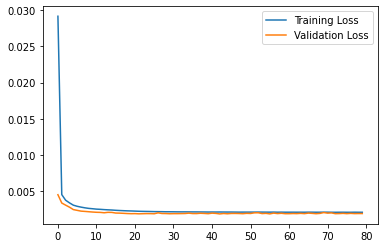

In [ ]:
#1D-CNN Autoencoder (Latent Space = Matrix):

# Parameters:
dropoutrate = 0.2
kernel_size = 3

#Build Encoder.
encoder_matrix = Sequential([
Conv1D(filters = 10, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "he_uniform", input_shape= (total_instances_trans.shape[1], total_instances_trans.shape[2])),
MaxPooling1D(3),
BatchNormalization(),
Dropout(dropoutrate),
Conv1D(filters = 20, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "he_uniform"),
MaxPooling1D(3),
BatchNormalization(),
Dropout(dropoutrate),
Conv1D(filters = 40, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "he_uniform"),
MaxPooling1D(2),
BatchNormalization(),
Dropout(dropoutrate),
Conv1D(filters = 3, kernel_size = kernel_size, activation='leaky_relu', padding='same', kernel_initializer = "he_uniform"),
])

#Build Decoder.
decoder_matrix = Sequential ([
Conv1D(filters = 40, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "he_uniform"),
UpSampling1D(2),
BatchNormalization(),
Conv1D(filters = 20, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "he_uniform"),
UpSampling1D(3),
BatchNormalization(),
Conv1D(filters=10, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "he_uniform"),
UpSampling1D(3),
BatchNormalization(),
Conv1D(filters=3, kernel_size = 1, padding="same", kernel_initializer = "he_uniform", activation = "sigmoid")
])

#Merge models to Autoencoder.
input = Input(shape=(total_instances_trans.shape[1], total_instances_trans.shape[2]))
output = encoder_matrix(input)
output = decoder_matrix(output)
conv_autoencoder_matrix = Model(inputs = input, outputs = output)
nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
conv_autoencoder_matrix.compile(optimizer=nadam, loss='mse')
conv_autoencoder_matrix.summary()
conv_autoencoder_matrix.layers[1].summary()
conv_autoencoder_matrix.layers[2].summary()
history = conv_autoencoder_matrix.fit(train, train, batch_size=32, epochs=80, validation_split=0.2)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
conv_autoencoder_matrix.save('conv_autoencoder_matrix.h5')
#new_model = keras.models.load_model('path_to_my_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 468, 3)]          0         
                                                                 
 sequential (Sequential)     (None, 15)                4988      
                                                                 
 sequential_1 (Sequential)   (None, 468, 3)            4991      
                                                                 
Total params: 9,979
Trainable params: 9,699
Non-trainable params: 280
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 468, 10)           100       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 

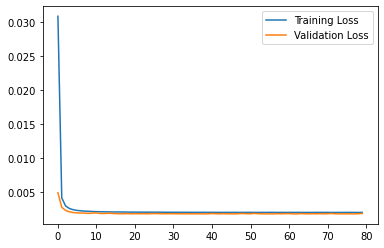

In [25]:
#1D-CNN Autoencoder (Latent Space = Flaten Vector):

# Parameters:
dropoutrate = 0.2
kernel_size = 3
encoded_dim = 15

#Build Encoder.
encoder_vector = Sequential([
Conv1D(filters = 10, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "he_uniform", input_shape= (total_instances_trans.shape[1], total_instances_trans.shape[2])),
MaxPooling1D(3),
BatchNormalization(),
Dropout(dropoutrate),
Conv1D(filters = 20, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "he_uniform"),
MaxPooling1D(3),
BatchNormalization(),
Dropout(dropoutrate),
Conv1D(filters = 40, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "he_uniform"),
MaxPooling1D(2),
BatchNormalization(),
Dropout(dropoutrate),
Conv1D(filters = 3, kernel_size = kernel_size, activation='leaky_relu', padding='same', kernel_initializer = "he_uniform"),
Flatten(),
Dense(encoded_dim, activation='relu', kernel_initializer = "he_uniform"),
])

#Build Decoder.
decoder_vector = Sequential ([
Dense(78, activation='relu', kernel_initializer = "he_uniform", input_shape=(encoded_dim,)),
Reshape((26,3)),
Conv1D(filters = 40, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "he_uniform"),
UpSampling1D(2),
BatchNormalization(),
Conv1D(filters = 20, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "he_uniform"),
UpSampling1D(3),
BatchNormalization(),
Conv1D(filters=10, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "he_uniform"),
UpSampling1D(3),
BatchNormalization(),
Conv1D(filters=3, kernel_size = 1, padding="same", kernel_initializer = "he_uniform", activation = "sigmoid")
])

#Merge models to Autoencoder.
input = Input(shape=(total_instances_trans.shape[1], total_instances_trans.shape[2]))
output = encoder_vector(input)
output = decoder_vector(output)
conv_autoencoder_vector = Model(inputs = input, outputs = output)
nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
conv_autoencoder_vector.compile(optimizer=nadam, loss='mse')
conv_autoencoder_vector.summary()
conv_autoencoder_vector.layers[1].summary()
conv_autoencoder_vector.layers[2].summary()
history = conv_autoencoder_vector.fit(train, train, batch_size=32, epochs=80, validation_split=0.2)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
conv_autoencoder_vector.save('conv_autoencoder_vector.h5')
#new_model = keras.models.load_model('path_to_my_model.h5')

-------------------- Test Evaluation Results--------------------
X RMSE - Mean: 0.08452082237844852
X RMSE - Max: 0.27498165752636283

Y RMSE - Mean: 0.0963044823217696
Y RMSE - Max: 0.26082823533867283

Z RMSE - Mean: 0.0928158051411886
Z RMSE - Max: 0.2726063890224589



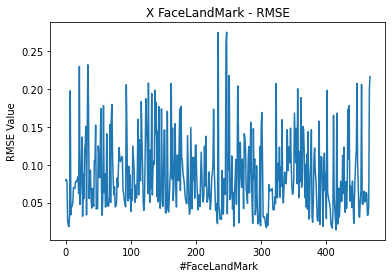

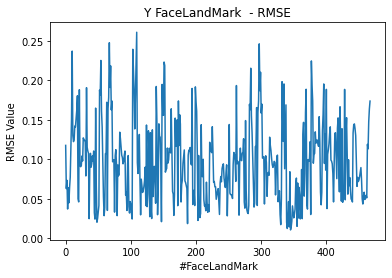

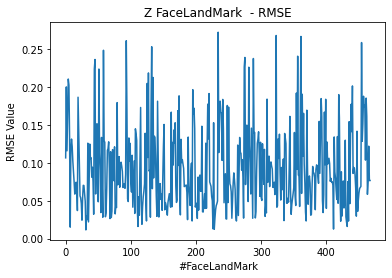

In [ ]:
#Calculate Test dataset RMSE - Conv Autoencoder (Latent Space = Matrix)
test_pred = conv_autoencoder_matrix.predict(test)

print("-------------------- Test Evaluation Results--------------------")
test_mae_loss = np.sqrt(np.mean(((test_pred - test)*(test_pred - test)), axis=0))

x_rmse = test_mae_loss[:,0]
print("X RMSE - Mean:", np.mean(x_rmse, axis=0))
print("X RMSE - Max:", np.max(x_rmse, axis=0))
print("")
y_rmse = test_mae_loss[:,1]
print("Y RMSE - Mean:", np.mean(y_rmse, axis=0))
print("Y RMSE - Max:", np.max(y_rmse, axis=0))
print("")
z_rmse = test_mae_loss[:,2]
print("Z RMSE - Mean:", np.mean(z_rmse, axis=0))
print("Z RMSE - Max:", np.max(z_rmse, axis=0))
print("")

facelandmarks = np.array(list(range(0, len(x_rmse))))

plt.title("X FaceLandMark - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,x_rmse) 
plt.show()

plt.title("Y FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,y_rmse) 
plt.show()

plt.title("Z FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,z_rmse) 
plt.show()

-------------------- Test Evaluation Results--------------------
X RMSE - Mean: 0.06647929322410638
X RMSE - Max: 0.19095008943378952

Y RMSE - Mean: 0.060480425883823186
Y RMSE - Max: 0.23943496476355527

Z RMSE - Mean: 0.06445878706944802
Z RMSE - Max: 0.2393459920847486



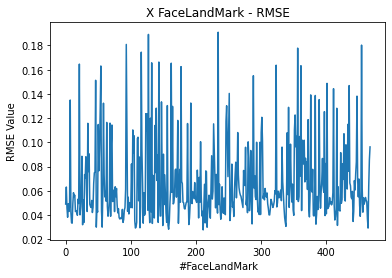

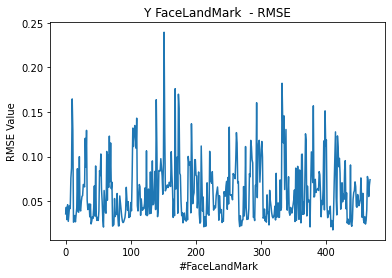

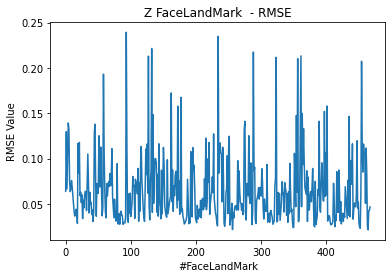

In [26]:
#Calculate Test dataset RMSE - Conv Autoencoder (Latent Space = Vector)
test_pred = conv_autoencoder_vector.predict(test)

print("-------------------- Test Evaluation Results--------------------")
test_mae_loss = np.sqrt(np.mean(((test_pred - test)*(test_pred - test)), axis=0))

x_rmse = test_mae_loss[:,0]
print("X RMSE - Mean:", np.mean(x_rmse, axis=0))
print("X RMSE - Max:", np.max(x_rmse, axis=0))
print("")
y_rmse = test_mae_loss[:,1]
print("Y RMSE - Mean:", np.mean(y_rmse, axis=0))
print("Y RMSE - Max:", np.max(y_rmse, axis=0))
print("")
z_rmse = test_mae_loss[:,2]
print("Z RMSE - Mean:", np.mean(z_rmse, axis=0))
print("Z RMSE - Max:", np.max(z_rmse, axis=0))
print("")

facelandmarks = np.array(list(range(0, len(x_rmse))))

plt.title("X FaceLandMark - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,x_rmse) 
plt.show()

plt.title("Y FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,y_rmse) 
plt.show()

plt.title("Z FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,z_rmse) 
plt.show()

In [ ]:
conv_autoencoder_vector = tf.keras.models.load_model('conv_autoencoder_vector.h5')

## Capacitive Data Processing for Regressor (Using Vector Decoder):

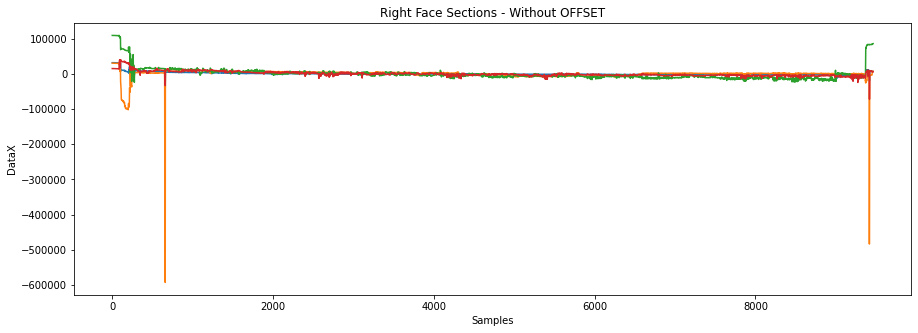

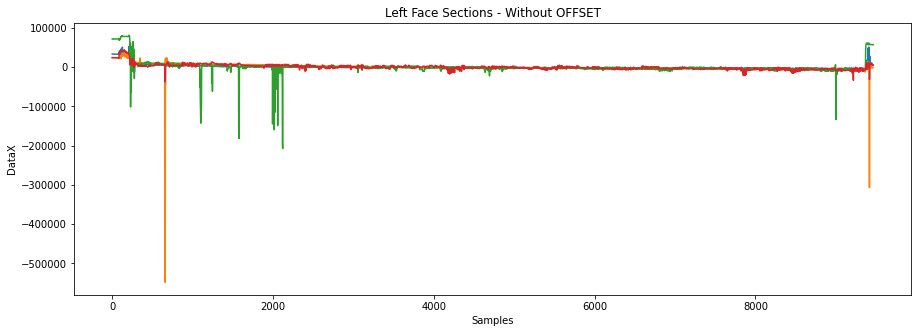

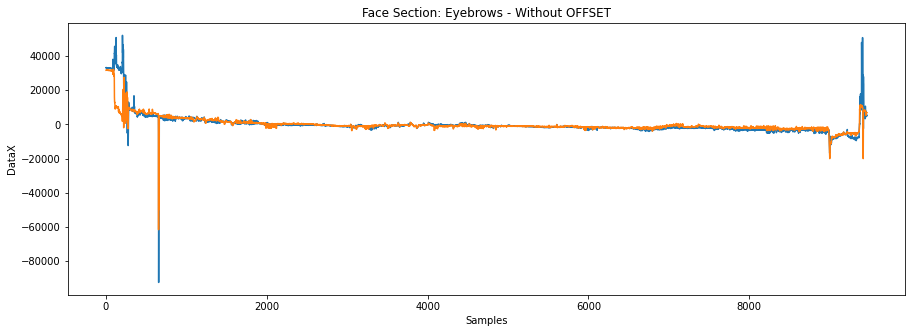

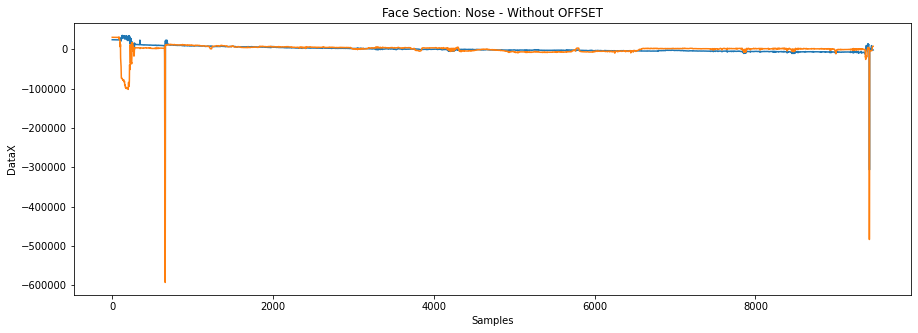

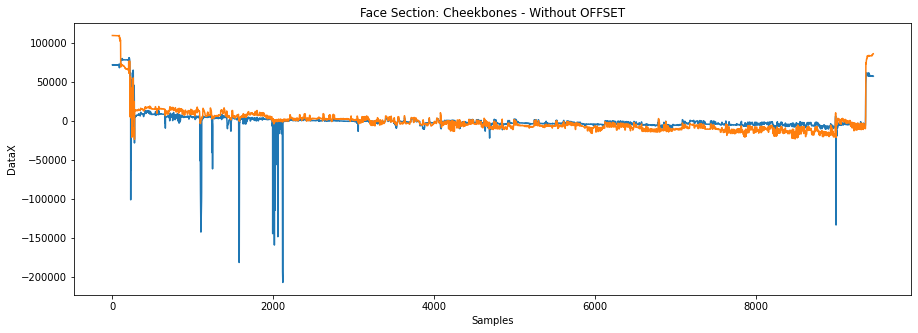

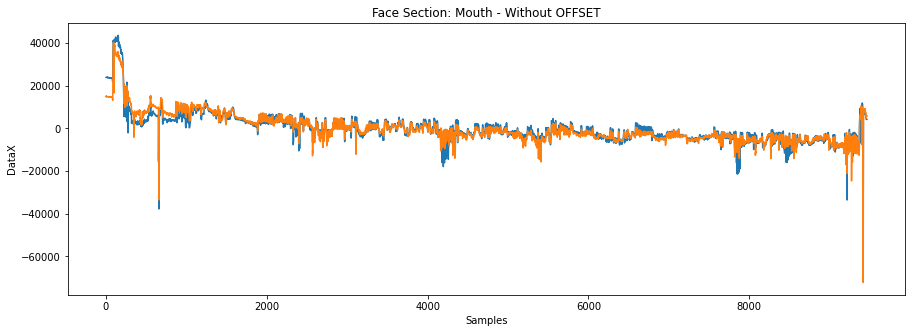

27508
Number of Cap samples in File #1:  9465
Number of Frames in Video #1:  27477
Number of Samples Video #1 - FacelandMarks after Sync:  27360
Number of Samples File #1 - Capacitive Data after Sync:  9286
-------------------- Features & Target Dimensions --------------------
Shape of Capacitive Data as Features: (9119, 20, 8)
Face Frame Synchronization: 27
Shape of Encoded FaceLandMark points as Targets: (9119, 15)
-------------------- Results after Train/Test Split --------------------
Size of time features TRAIN data array: (7295, 20, 8)
Size of time features TEST data array: (1824, 20, 8)
Size of time target TRAIN data array: (7295, 15)
Size of time target TEST data array: (1824, 15)


In [41]:
n_samples = 1
downsample = 3
window_cap_size = 20 #(2 secs)
n_feature_values = 8
features_cap_timeslice = []
targets_facelandmark_timeslice = []

for i in range(n_samples):
    #Reading EXCEL file coming from SerialPort data:
    # Change name of file to read.
    file_number = str(i+1)
    file_name_cap = "/content/drive/MyDrive/Capacitive_Values (" + file_number + ").json"
    video_path = "/content/drive/MyDrive/Video_FaceShield (" + file_number + ").MOV"
    # Read Excel file.
    dataset_cap = get_capacitive_values(file_name_cap)
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found = get_facelandmarks_video(video_path)
    #Manual Sync:
    
    print("Number of Cap samples in File #" + str(file_number) + ": ", len(dataset_cap))
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    
    #Synchronization between Capacitive and FaceLandmarks data.
    sync_thr = 30
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z = sync_facelandmarks(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found, sync_thr)
    sync_dataset_cap = sync_cap(dataset_cap, frame_hand_found, sync_thr)

    print("Number of Samples Video #" + str(file_number) + " - FacelandMarks after Sync: " , len(dataset_facelandmarks_x))
    print("Number of Samples File #" + str(file_number) + " - Capacitive Data after Sync: " , len(sync_dataset_cap))

    #Capacitive data channel Normalization.
    norm_dataset_cap = normalize_capacitance_values(sync_dataset_cap)

    # Generate train features and target from windowing process.
    features = generate_input_time_slices(norm_dataset_cap, window_cap_size, n_feature_values)
    targets = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    
    #CHANGE:
    if (len(features)>len(targets)):
      features = features[0:len(targets)]
    else:
      targets = targets[0:len(features)]

    # If it is the first generation of time features.
    if (i == 0):
        total_features = features
        total_targets = targets
    # If it is not the first generation of time features.
    else:
        total_features = np.concatenate((total_features, features), axis=0)
        total_targets = np.concatenate((total_targets, targets), axis=0)
          
print("-------------------- Features & Target Dimensions --------------------")

print("Shape of Capacitive Data as Features:", total_features.shape)
print("Face Frame Synchronization:", frame_hand_found)
#Get the latent space features from the 468 Facelandmarks using the encoder from the trained autoencoder:
total_targets = total_targets.transpose(0,2,1)
total_enconded_target = encoder_vector.predict(total_targets)
print("Shape of Encoded FaceLandMark points as Targets:", total_enconded_target.shape)

#Split Train and Test dataset:
X_train, X_test, y_train, y_test = split_train_test(total_features, total_enconded_target)

#Print results after Train/Test.
print("-------------------- Results after Train/Test Split --------------------")
print("Size of time features TRAIN data array:", X_train.shape)
print("Size of time features TEST data array:", X_test.shape)
print("Size of time target TRAIN data array:", y_train.shape)
print("Size of time target TEST data array:", y_test.shape)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 19, 32)            544       
                                                                 
 batch_normalization_10 (Bat  (None, 19, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_11 (Conv1D)          (None, 18, 32)            2080      
                                                                 
 batch_normalization_11 (Bat  (None, 18, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 18, 32)            0         
                                                                 
 flatten_2 (Flatten)         (None, 576)              

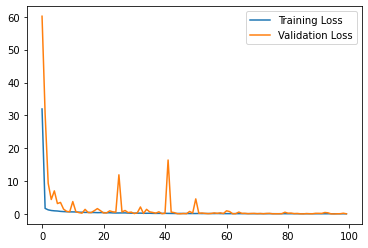

In [42]:
#Prepare data for CNN model.
x_train = X_train
#n_output = enconded dimension.
n_output = y_train.shape[1]

#CNN:
# Parameters:
n_filters = 32
EPOCHS_CNN = 100

# Define architecture of CNN.
model_CNN = Sequential()
model_CNN.add(Conv1D(filters=n_filters, kernel_size=2, activation='relu', kernel_initializer = "he_uniform", input_shape=(x_train.shape[1], x_train.shape[2])))
model_CNN.add(BatchNormalization())
model_CNN.add(Conv1D(filters=n_filters, kernel_size=2, activation='relu', kernel_initializer = "he_uniform"))
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.2))
model_CNN.add(Flatten())
model_CNN.add(Dense(50, activation='relu', kernel_initializer = "glorot_uniform"))
model_CNN.add(Dense(n_output))

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_CNN.compile(loss='mse', optimizer=nadam, metrics=['mse'])
# Show summary of model.
model_CNN.summary()
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history_CNN = model_CNN.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=EPOCHS_CNN)

plt.plot(history_CNN.history["loss"], label="Training Loss")
plt.plot(history_CNN.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

-------------------- Test Evaluation Results--------------------
Test RMSE 1D-CNN [0.796798   0.08325911 0.57067424 0.49761844 0.841718   0.5703242
 0.04502771 0.09038826 0.07753039 0.04518587 0.04677032 0.04953602
 0.04400155 0.08771518 0.06571757]

RMSE - Mean: 0.26081765
RMSE - Max: 0.841718



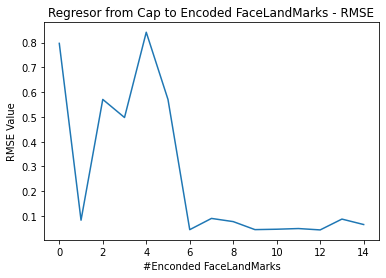

In [45]:
#### Calculate Test dataset RMSE for 1D-CNN ####
test_pred = model_CNN.predict(X_test)

print("-------------------- Test Evaluation Results--------------------")
test_rmse_loss = np.sqrt(np.mean(((test_pred - y_test)*(test_pred - y_test)), axis=0))
print("Test RMSE 1D-CNN", test_rmse_loss)
print("")
print("RMSE - Mean:", np.mean(test_rmse_loss, axis=0))
print("RMSE - Max:", np.max(test_rmse_loss, axis=0))
print("")

enconder_dimension = np.array(list(range(0, len(test_rmse_loss))))
plt.title("Regresor from Cap to Encoded FaceLandMarks - RMSE") 
plt.xlabel("#Enconded FaceLandMarks") 
plt.ylabel("RMSE Value") 
plt.plot(enconder_dimension,test_rmse_loss) 
plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 80)                12880     
                                                                 
 dropout_7 (Dropout)         (None, 80)                0         
                                                                 
 dense_11 (Dense)            (None, 60)                4860      
                                                                 
 dropout_8 (Dropout)         (None, 60)                0         
                                                                 
 dense_12 (Dense)            (None, 40)                2440      
                                                                 
 dense_13 (Dense)            (None, 15)                615       
                                                                 
Total params: 20,795
Trainable params: 20,795
Non-trai

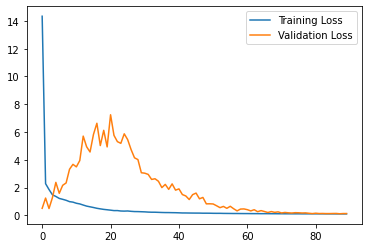

In [46]:
#Prepare data for MLP model.
x_train = X_train
#Flaten train vector.
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
#n_output = enconded dimension.
n_output = y_train.shape[1]

EPOCHS_MLP = 90

model_MLP = Sequential()
model_MLP.add(Dense(80, activation='relu', input_dim=x_train.shape[1], kernel_initializer = "glorot_uniform"))
model_CNN.add(BatchNormalization())
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(60, activation='relu', kernel_initializer = "glorot_uniform"))
model_CNN.add(BatchNormalization())
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(40, activation='relu', kernel_initializer = "glorot_uniform"))
model_MLP.add(Dense(n_output))

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_MLP.compile(loss='mse', optimizer=nadam, metrics=['mse']) #incluir R2
# Show summary of model.
model_MLP.summary()
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history_MLP = model_MLP.fit(x_train, y_train, batch_size=32, validation_split=0.20, epochs=EPOCHS_MLP)

plt.plot(history_MLP.history["loss"], label="Training Loss")
plt.plot(history_MLP.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

-------------------- Test Evaluation Results--------------------
Test RMSE MLP [0.7580896  0.00313091 0.3098382  0.49128154 0.8038851  0.5667385
 0.00214009 0.03738342 0.02013993 0.00335107 0.00576159 0.00412634
 0.00249092 0.00266585 0.00315577]

RMSE - Mean: 0.20094524
RMSE - Max: 0.8038851



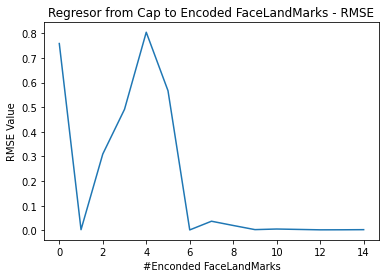

In [47]:
#### Calculate Test dataset RMSE for MLP ####
x_test = X_test
#Flaten train vector.
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))
test_pred = model_MLP.predict(x_test)

print("-------------------- Test Evaluation Results--------------------")
test_rmse_loss = np.sqrt(np.mean(((test_pred - y_test)*(test_pred - y_test)), axis=0))
print("Test RMSE MLP", test_rmse_loss)
print("")
print("RMSE - Mean:", np.mean(test_rmse_loss, axis=0))
print("RMSE - Max:", np.max(test_rmse_loss, axis=0))
print("")

enconder_dimension = np.array(list(range(0, len(test_rmse_loss))))
plt.title("Regresor from Cap to Encoded FaceLandMarks - RMSE") 
plt.xlabel("#Enconded FaceLandMarks") 
plt.ylabel("RMSE Value") 
plt.plot(enconder_dimension,test_rmse_loss) 
plt.show()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_38 (Reshape)        (None, 20, 8, 1)          0         
                                                                 
 bidirectional_47 (Bidirecti  (None, 20, 8, 39)        62712     
 onal)                                                           
                                                                 
 dropout_77 (Dropout)        (None, 20, 8, 39)         0         
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 6, 4, 39)         0         
 g2D)                                                            
                                                                 
 bidirectional_48 (Bidirecti  (None, 6, 4, 78)         365664    
 onal)                                                           
                                                     

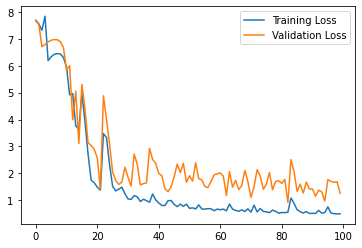

In [ ]:
#Prepare data for ConvLSTM1D model (Use encoder_matrix)
x_train = X_train
#n_output = enconded dimension.
n_output = (y_train.shape[1], y_train.shape[2])

# Parameters:
EPOCHS_CNN = 100
kernel_size = 5

regressor = Sequential([
layers.Input((x_train.shape[1], x_train.shape[2])),
layers.Reshape((x_train.shape[1], x_train.shape[2],1)),
layers.Bidirectional(layers.ConvLSTM1D(filters = 39, kernel_size = kernel_size, padding='same', activation='relu', return_sequences=True), merge_mode='sum'),
layers.Dropout(dropoutrate),
layers.MaxPooling2D(pool_size=(3, 2)),
layers.Bidirectional(layers.ConvLSTM1D( filters = 78, kernel_size = kernel_size, padding='same', activation='relu', return_sequences=True), merge_mode='sum'),
layers.Dropout(dropoutrate),
layers.MaxPooling2D(pool_size=(4, 3)),
layers.Reshape((y_train.shape[1], y_train.shape[2]))
])

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
regressor.compile(optimizer=nadam, loss='mse')
regressor.summary()

history_regressor = regressor.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=EPOCHS_CNN)
plt.plot(history_regressor.history["loss"], label="Training Loss")
plt.plot(history_regressor.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Complete Model Evaluation:

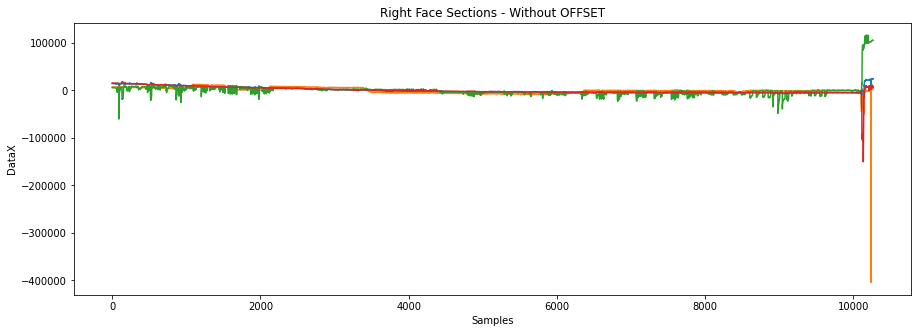

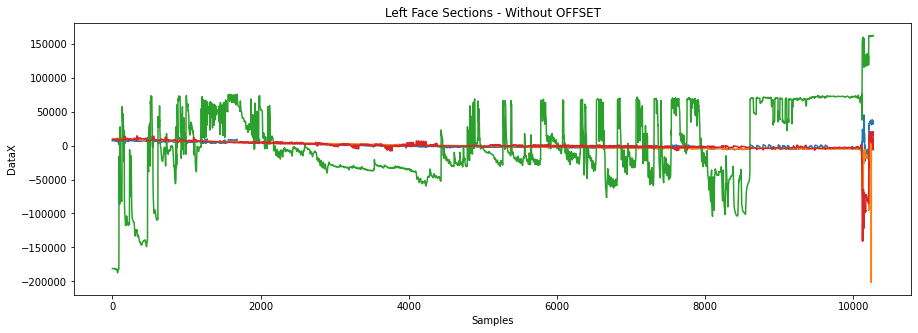

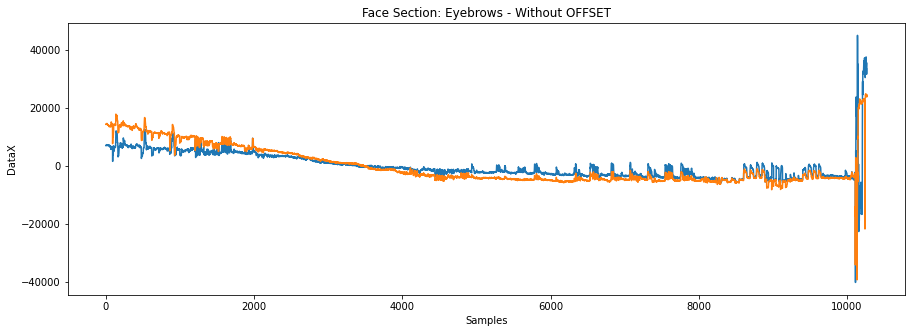

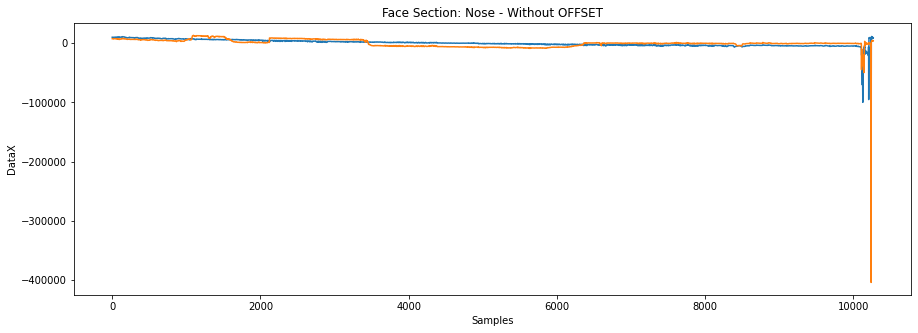

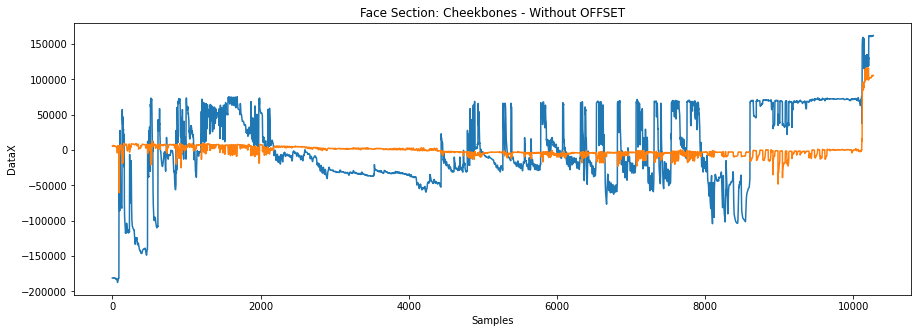

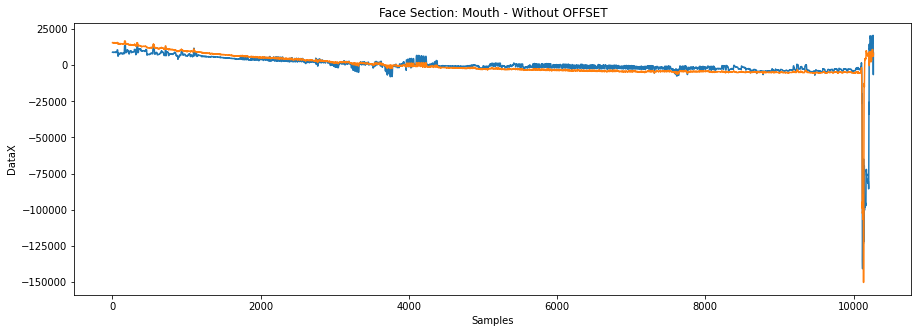

32319
Number of Cap samples in File #1:  10269
Number of Frames in Video #1:  32317
-------------------- Features & Target Dimensions --------------------
Frame Synchronization: 480
Shape of Capacitive Data as Features: (10230, 20, 8)
Shape of Encoded FaceLandMark points as Targets: (10230, 3, 468)


In [48]:
n_samples = 1
n_test_sets = 4
downsample = 3
window_cap_size = 20 #(2 secs)
n_feature_values = 8
features_cap_timeslice = []
targets_facelandmark_timeslice = []

for i in range(n_samples):
    #Reading EXCEL file coming from SerialPort data:
    # Change name of file to read.
    file_number = str(i+1)
    file_name_cap = "/content/drive/MyDrive/Capacitive_Values_Test (" + file_number + ").json"
    video_path = "/content/drive/MyDrive/Video_FaceShield_Test (" + file_number + ").MOV"
    # Read Excel file.
    dataset_cap = get_capacitive_values(file_name_cap)
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found = get_facelandmarks_video(video_path)
    frame_hand_found = 480
    print("Number of Cap samples in File #" + str(file_number) + ": ", len(dataset_cap))
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    
   #Capacitive data channel Normalization.
    norm_dataset_cap = normalize_capacitance_values(dataset_cap)

    # Generate train features and target from windowing process.
    features = generate_input_time_slices(dataset_cap, window_cap_size, n_feature_values)
    targets = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    
    #CHANGE (MISSING DATA SYNCHRONIZATION)
    if (len(features)>len(targets)):
      features = features[0:len(targets)]
    else:
      targets = targets[0:len(features)]

    # If it is the first generation of time features.
    if (i == 0):
        total_features = features
        total_targets = targets
    # If it is not the first generation of time features.
    else:
        total_features = np.concatenate((total_features, features), axis=0)
        total_targets = np.concatenate((total_targets, targets), axis=0)
          
print("-------------------- Features & Target Dimensions --------------------")
print("Frame Synchronization:", frame_hand_found)
print("Shape of Capacitive Data as Features:", total_features.shape)
print("Shape of Encoded FaceLandMark points as Targets:", total_targets.shape)

In [97]:
y_test = y_test.transpose(0,2,1)

In [100]:
y_test.shape

(10230, 3, 468)

-------------------- Test Evaluation Results--------------------
X RMSE - Mean: 0.45750479562910656
X RMSE - Max: 0.6523785574767492

Y RMSE - Mean: 0.3423428004682712
Y RMSE - Max: 0.48082910598991374

Z RMSE - Mean: 0.13842283463096647
Z RMSE - Max: 1.0571890279574347



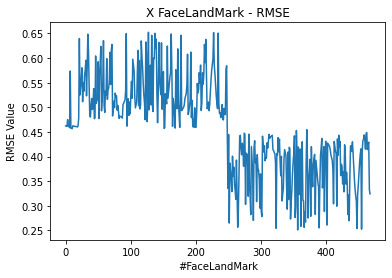

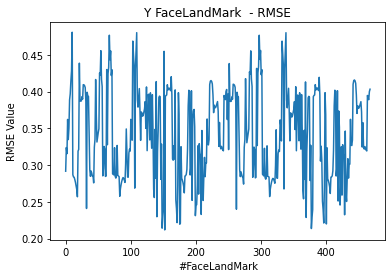

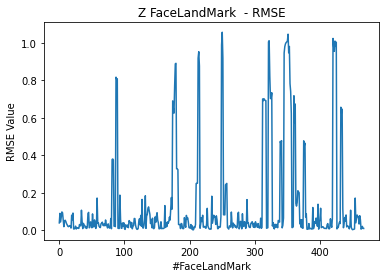

In [102]:
#### Calculate Test RMSE for complete Model ####

#For MLP - Flaten features vector.
#Concatenate MLP Regressor and Decoder.
cap_face_model = Model(inputs = model_MLP.inputs, outputs = decoder_vector(model_MLP.outputs))
x_test = total_features.reshape((total_features.shape[0], total_features.shape[1]*total_features.shape[2]))
y_test = total_targets
y_test = y_test.transpose(0,2,1)

#For 1DCNN - Flaten features vector.
#Concatenate 1DCNN Regressor and Decoder.
#cap_face_model = Model(inputs = model_CNN.inputs, outputs = decoder_vector(model_CNN.outputs))
#x_test = total_features
#y_test = total_targets
#y_test = y_test.transpose(0,2,1)

#Compute predictions with complete model:
test_pred = cap_face_model.predict(x_test)

#Print evaluation results - RMSE:
print("-------------------- Test Evaluation Results--------------------")

#Calculate RMSE:
test_rmse_loss = np.sqrt(np.mean(((test_pred - y_test)*(test_pred - y_test)), axis=0))

x_rmse = test_rmse_loss[:,0]
print("X RMSE - Mean:", np.mean(x_rmse, axis=0))
print("X RMSE - Max:", np.max(x_rmse, axis=0))
print("")
y_rmse = test_rmse_loss[:,1]
print("Y RMSE - Mean:", np.mean(y_rmse, axis=0))
print("Y RMSE - Max:", np.max(y_rmse, axis=0))
print("")
z_rmse = test_rmse_loss[:,2]
print("Z RMSE - Mean:", np.mean(z_rmse, axis=0))
print("Z RMSE - Max:", np.max(z_rmse, axis=0))
print("")

facelandmarks = np.array(list(range(0, len(x_rmse))))

plt.title("X FaceLandMark - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,x_rmse) 
plt.show()

plt.title("Y FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,y_rmse) 
plt.show()

plt.title("Z FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,z_rmse) 
plt.show()

In [74]:
test_pred.shape
test_pred = test_pred.transpose(0,2,1)
test_pred.shape

(10230, 468, 3)

In [53]:
y_test.shape

(10230, 468, 3)

In [77]:
facial_landmarks

0

In [ ]:
width = 350
height = 210
from google.colab.patches import cv2_imshow
blank_image = np.zeros((350,210,3), np.uint8)
n_test_sample = 20
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter("/content/drive/MyDrive/output_test", fourcc, 30.0, (350,210))

#for frame in range (len(test_pred)):
for frame in range (n_test_sample):
  facial_landmarks = test_pred[frame]
  #The models generate 468 normalized [x,y,z] facial landmarks. 
  for face_point in facial_landmarks:
    #Denormalize: multiply X coordinate by width and Y coordinate by height.
    x = int(face_point[0] * height)
    y = int(face_point[1] * width)
    #Save tuple of normalized (x,y) coordinates.
    #Attach denormalize facial landmarks to frame.
    cv2.circle(blank_image,(x,y),2,(100,100,0),-1)
  
  out.write(blank_image)
  cv2_imshow(blank_image)
  cv2.waitKey(0)